In [5]:
from pathlib import Path

# Automatically get the base path of your project
base_path = Path.cwd().parents[0]  # adjust .parents[0] if needed
print("Base path of the project:", base_path)

Base path of the project: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db


In [ ]:
# This code is more robust and will work regardless of the current working directory.
# Make sure that base_path is defined correctly.
# Install the requirements from the requirements.txt file
#!pip3 install -r "{base_path}/requirements.txt"

# Peptide Identification Pipeline using Custom Database

In this project, we aim to develop an algorithm that identifies the microbial composition of a mass spectrometry (MS) sample based on de novo peptide sequencing data. 
Using the predicted peptides, we reconstruct a custom protein sequence database that is optimized for the specific microbial community in the sample.

The pipeline involves several key steps:
- Filtering the de novo peptides based on Average Local Confidence (ALC) scores to retain only high-confidence sequences.
- Cleaning peptide sequences to remove post-translational modification notations.
- Determining the taxonomic origin of peptides by querying UniProt in batch mode.
- Building the microbial community composition based on the taxonomy assignments.
- Constructing a targeted protein database by collecting protein sequences from the identified taxa.
- Reducing database redundancy through clustering to optimize search efficiency and minimize false positives.

By tailoring the database to the actual community composition, we aim to achieve more accurate protein identifications in metaproteomic studies — approaching the performance of genome-based identification strategies, without the need for extensive metagenomic sequencing.

As a first step, we will filter the de novo sequencing results to retain only high-confidence peptides with an Average Local Confidence (ALC) score greater than 70%.

In [6]:
# Import necessary libraries
import pandas as pd

# Load the de novo peptide data
file_path = base_path / "de_novo_data" / "de_novo_garmerwolde.csv"
df = pd.read_csv(file_path)

# Display the dataset dimensions
print(f"Original dataset shape: {df.shape}")

# Display rows 24219 to 24227 (Python is zero-indexed → use iloc[24218:24227+1])
print("Original Data (rows 24219–24227):")
display(df.iloc[24218:24228])

# Filter peptides with ALC (%) > 70
filtered_df = df[df["ALC (%)"] > 70]

# Display the filtered dataset dimensions
print(f"Filtered dataset shape: {filtered_df.shape}")

# Display same rows (if they exist after filtering — some will be removed)
print("Filtered Data (rows 24219-24227):")
display(filtered_df.iloc[24218:24228])  # This only works if enough rows remain after filtering
print(f"Number of peptides filtered out: {df.shape[0] - filtered_df.shape[0]}")

Original dataset shape: (189185, 20)
Original Data (rows 24219–24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
24218,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,KYAYFPVWVNDDKMSLPLR,F2:51275,19,76,68,19,781.3988,3,143.42,142.11,0.0,2341.1929,-7.8,NaN,45 39 41 35 33 43 89 98 98 94 95 96 94 90 83 4...,KYAYFPVWVNDDKMSLPLR,HCD
24219,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:35083,MWALDLR,F1:38190,7,76,78,7,452.7394,2,113.16,129.39,34600.0,903.4636,0.6,NaN,56 71 84 79 79 85 90,MWALDLR,HCD
24220,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:98838,LAAALTPAPVLAK,F2:33083,13,76,70,13,618.3896,2,100.95,110.95,13200000.0,1234.7649,-0.2,NaN,48 50 80 99 100 100 99 96 33 31 48 45 82,LAAALTPAPVLAK,HCD
24221,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:83383,APMSGLQNWK,F2:29687,10,76,70,10,566.2845,2,92.40,83.12,215000.0,1130.5542,0.3,NaN,96 94 85 92 82 41 28 21 69 92,APMSGLQNWK,HCD
24222,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:107262,SLTAPSGVPGM(+15.99)FK,F2:26077,13,76,67,13,654.3237,2,83.51,83.66,75700.0,1306.6592,-20.1,Oxidation (M),37 46 79 93 95 96 88 84 23 17 26 89 97,SLTAPSGVPGM(+15.99)FK,HCD
24223,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:139236,EVQAWSWWWM(+15.99)TRRAAMDVPGR,F2:49588,21,76,68,21,879.0955,3,139.45,141.68,822000.0,2634.2371,10.4,Oxidation (M),37 25 33 44 44 41 81 84 90 88 90 40 52 96 95 8...,EVQAWSWWWM(+15.99)TRRAAMDVPGR,HCD
24224,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:3957,MGFYGGR,F2:13573,7,76,68,7,394.1815,2,50.45,47.75,376000.0,786.3483,0.3,NaN,17 29 90 86 80 83 90,MGFYGGR,HCD
24225,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:103943,TLGALDGTN(+.98)MNR,F1:23486,12,76,71,12,632.3035,2,78.32,67.85,3660000.0,1262.5925,0.0,Deamidation (NQ),21 21 26 76 99 98 90 88 70 82 91 93,TLGALDGTN(+.98)MNR,HCD
24226,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:23734,LGGLSSAMK,F1:16822,9,76,75,9,432.2354,2,59.98,63.31,416000.0,862.4582,-2.4,NaN,62 77 48 88 82 73 68 78 97,LGGLSSAMK,HCD
24227,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LDQ(+.98)AHLYNWQWYR,F2:50574,13,76,77,13,897.4365,2,141.76,127.6,0.0,1792.8320,14.8,Deamidation (NQ),31 38 40 61 54 99 98 96 96 94 95 98 100,LDQ(+.98)AHLYNWQWYR,HCD


Filtered dataset shape: (32111, 20)
Filtered Data (rows 24219-24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
25984,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LVTTDANGWYNK,F2:16205,12,75,73,12,691.3395,2,57.63,71.8,0.0,1380.6675,-2.1,NaN,59 60 95 95 95 89 83 70 69 28 43 98,LVTTDANGWYNK,HCD
25985,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:39500,KATSLMDR,F2:7950,8,75,76,8,461.2376,2,32.97,17.78,841000.0,920.4749,-15.5,NaN,77 34 38 87 93 88 96 94,KATSLMDR,HCD
25986,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:103841,WAADLDQ(+.98)MVTK,F2:42699,11,75,75,11,639.8031,2,123.18,107.95,110000.0,1277.5962,-3.6,Deamidation (NQ),78 60 90 90 89 94 89 69 28 41 98,WAADLDQ(+.98)MVTK,HCD
25989,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:18876,Q(+.98)VYLHMDGFR,F1:35026,10,75,72,10,422.8690,3,105.90,95.37,300000.0,1265.5862,-0.9,Deamidation (NQ),26 28 45 61 92 95 98 92 94 96,Q(+.98)VYLHMDGFR,HCD
25990,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:113009,TLLPALYLLQGR,F2:54646,12,75,74,12,679.4126,2,151.38,164.41,25200.0,1356.8130,-1.7,NaN,51 50 50 33 82 89 93 95 85 79 88 98,TLLPALYLLQGR,HCD
25991,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:139595,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,F1:54391,22,75,72,22,847.3984,3,151.74,161.24,6010000.0,2539.1841,-4.2,Deamidation (NQ); Carbamidomethylation,49 40 57 62 82 96 69 44 92 49 28 34 96 97 97 8...,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,HCD
25993,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,-,YHDALTYVWNWGGFTGK,F1:45457,17,75,85,17,1007.9756,2,130.26,163.81,0.0,2013.9373,-0.3,NaN,34 20 62 78 99 99 98 98 98 97 98 97 97 98 98 9...,YHDALTYVWNWGGFTGK,HCD
25994,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:852,NSLAVLR,F1:12592,7,75,81,7,386.7372,2,48.50,66,1480000.0,771.4603,-0.4,NaN,61 60 82 92 94 94 86,NSLAVLR,HCD
25995,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:141090,NYLDDLR,F2:41876,7,75,85,7,908.4518,1,121.32,83.38,208000.0,907.4399,5.0,NaN,85 83 85 82 85 88 90,NYLDDLR,HCD
25997,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:129117,YM(+15.99)APQEVGPGSPFR,F2:34615,14,75,78,14,776.3701,2,104.14,93.71,57400.0,1550.7188,4.5,Oxidation (M),37 35 43 41 90 96 95 97 93 92 94 82 95 100,YM(+15.99)APQEVGPGSPFR,HCD


Number of peptides filtered out: 157074


In [7]:
# Define the wrangle_peptides function
import re

def wrangle_peptides(sequence: str, ptm_filter: bool=True, li_swap: bool=True) -> str:
    """Process peptide sequences by removing post-translational modifications
    and/or equating Leucine and Isoleucine amino acids.

    Args:
        sequence (str): Peptide sequence string
        ptm_filter (bool, optional): Remove PTMs from sequence. Defaults to True.
        li_swap (bool, optional): Equate Leucine (L) and Isoleucine (I). Defaults to True.

    Returns:
        str: Processed sequence string
    """
    if ptm_filter:
        sequence = "".join(re.findall(r"[A-Z]+", sequence))
    if li_swap:
        sequence = sequence.replace("L", "I")
    return sequence

# Apply wrangle_peptides function to the filtered data
filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))

print("Shape of the filtered DataFrame after adding the new column:")
display(filtered_df.shape)  # Check the shape of the DataFrame after adding the new column

# Display rows 11 to 21 (Python is 0-indexed, so need 10:21)
print("Cleaned Peptides (Rows 11–21):")
display(filtered_df[["Peptide", "Cleaned Sequence"]].iloc[10:21])

Shape of the filtered DataFrame after adding the new column:


C:\Temp\ipykernel_2060\2190476586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))


(32111, 21)

Cleaned Peptides (Rows 11–21):


,Peptide,Cleaned Sequence
10,TSLLN(+.98)YLR,TSIINYIR
11,VVQLTMQ(+.98)TQEK,VVQITMQTQEK
12,ATMSDFSPK,ATMSDFSPK
13,LSELTSLTSAPR,ISEITSITSAPR
14,VSQ(+.98)AVLAASSGR,VSQAVIAASSGR
15,VGLAWDR,VGIAWDR
16,YLPASC(+57.02)R,YIPASCR
17,ASVEDLLK,ASVEDIIK
18,YPDVATTHGGSATK,YPDVATTHGGSATK
19,VMGVAFN(+.98)R,VMGVAFNR


In [8]:
# Import necessary libraries
import requests

# Define the fetch_request function
def fetch_request(url: str, retries: int = 3, delay: int = 5) -> requests.Response:
    """Send GET request and return response object. Retries if server error encountered.

    Args:
        url (str): input URL.
        retries (int, optional): Number of retry attempts. Defaults to 3.
        delay (int, optional): Seconds to wait between retries. Defaults to 5 seconds.

    Raises:
        RuntimeError: If request fails after all retries.

    Returns:
        requests.Response: Response object
    """
    import time  # Import the time module to use sleep delays between retry attempts

    # Loop up to 'retries' times to attempt the request
    for attempt in range(retries):
        req_get = requests.get(url)  # Send a GET request to the provided URL

        if req_get.status_code == 200:
            return req_get  # If the response is successful (HTTP 200), return it immediately

        # If the response was not successful, print a message and wait before retrying
        print(f"Request failed with status {req_get.status_code}. Retrying ({attempt+1}/{retries}) in {delay} seconds...")
        time.sleep(delay)  # Pause for 'delay' seconds before the next attempt

    # If all retry attempts fail, construct an error message using the last received status code
    error_msg = f"Request failed after {retries} retries: statuscode {req_get.status_code}"
    raise RuntimeError(error_msg)  # Raise a RuntimeError to indicate the failure to the calling function

In [9]:
# Define the request_unipept_pept_to_lca function
def request_unipept_pept_to_lca(pept_df: pd.DataFrame, seq_col: str) -> pd.DataFrame:
    """From a dataset of peptides, fetch LCA taxonomy and rank from UniPept database.

    Args:
        pept_df (pd.DataFrame): Peptide dataset.
        seq_col (str): Column with peptide sequences.

    Returns:
        pd.DataFrame: Peptide sequences with LCA taxonomy and LCA rank.
    """
    # Base URL for the UniPept pept2lca API with equate_il=true (I and L treated as equal)
    base_url = "http://api.unipept.ugent.be/api/v1/pept2lca.json?equate_il=true"

    # Number of peptides to include per API request (due to API limits)
    batch_size = 100

    # Create a list of unique peptide strings in the correct API format: '&input[]=PEPTIDE'
    seq_series = ["&input[]=" + seq for seq in pept_df[seq_col].drop_duplicates()]

    # Initialize an empty DataFrame to collect all LCA results
    lca_df = pd.DataFrame(columns=[seq_col, "Global LCA", "Global LCA Rank"], dtype=object)

    # x is the index for batching through seq_series
    x = 0
    while True:
        # Get the next batch of peptides for the current request
        if x + batch_size >= len(seq_series):
            peptides = seq_series[x:]  # Last batch (may be smaller than batch_size)
        else:
            peptides = seq_series[x:x+batch_size]  # Normal batch of size 100

        # Concatenate the base URL with the batch of peptides to form the full request string
        req_str = "".join([base_url, *peptides])

        # Send the HTTP request and parse the JSON response
        response = fetch_request(req_str).json()

        # Convert each item in the response into a row in the DataFrame
        # Use `.get()` with default value "Unknown" in case a field is missing
        lca_df = pd.concat([
            lca_df,
            pd.DataFrame(
                [
                    (
                        elem.get("peptide", "Unknown"),     # peptide sequence
                        elem.get("taxon_id", "Unknown"),    # taxon ID (LCA)
                        elem.get("taxon_rank", "Unknown")   # taxonomic rank of LCA
                    )
                    for elem in response
                ],
                columns=[seq_col, "Global LCA", "Global LCA Rank"]
            )
        ])

        # Move the index forward by the batch size
        x += batch_size

        # Break the loop when all peptides have been processed
        if x >= len(seq_series):
            break

    # Return the full DataFrame with LCA results for all input peptides
    return lca_df

In [10]:
# Now run the function on our cleaned peptide dataset
# We pass filtered_df with the 'Cleaned Sequence' column

print("Fetching taxonomy information from UniPept...")
lca_results_df = request_unipept_pept_to_lca(filtered_df, seq_col="Cleaned Sequence")

# Display the first few results
print("LCA Mapping Results:")
display(lca_results_df.head())

Fetching taxonomy information from UniPept...
LCA Mapping Results:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
2,ITGMAFR,1,no rank
3,IGSDAYNQK,3379134,kingdom
4,IGATYDIFGDGK,1,no rank


In [11]:
# Display the lca dataset dimensions
print(f"LCA results dataset shape: {lca_results_df.shape}")

LCA results dataset shape: (8703, 3)


In [12]:
# Count the number of peptides per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Display the counts
print("Peptide counts per LCA rank:")
display(rank_counts)

Peptide counts per LCA rank:


Global LCA Rank
no rank          6608
species           820
domain            357
genus             273
class             144
strain            126
phylum            114
kingdom           108
family             61
order              36
subphylum          10
subfamily           8
subclass            7
subkingdom          6
subspecies          5
subgenus            5
infraorder          5
superclass          4
species group       3
suborder            1
tribe               1
varietas            1
Name: count, dtype: int64

In [13]:
# This code allows us to automatically define the allowed_ranks based on the frequency of occurrence in the dataset.
# Step 1: Replace 'no rank' with 'Unclassified' for clarity
lca_results_df["Global LCA Rank"] = lca_results_df["Global LCA Rank"].replace("no rank", "Unclassified")

# Step 2: Count how many peptides exist per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Step 3: Define canonical rank order (from general to specific)
canonical_rank_order = [
    "domain", "kingdom", "subkingdom", "superclass", "phylum", "subphylum",
    "class", "subclass", "order", "suborder", "infraorder", "family", "subfamily",
    "genus", "subgenus", "species group", "species", "subspecies",
    "strain", "varietas", "tribe"
]

# Step 4: Filter canonical ranks based on frequency threshold
rank_frequency_cutoff = 15
allowed_ranks = [rank for rank in canonical_rank_order if rank_counts.get(rank, 0) >= rank_frequency_cutoff]

# Step 5: Print the allowed ranks to verify order and contents
print("Allowed ranks based on cutoff and specificity:")
print(allowed_ranks)

# Step 6: Filter the DataFrame to only include allowed ranks
filtered_lca_df = lca_results_df[lca_results_df["Global LCA Rank"].isin(allowed_ranks)].copy()

# Step 7: Count how many times each taxon ID appears
taxon_counts = filtered_lca_df["Global LCA"].value_counts()

# Step 8: Apply a frequency cutoff (e.g. at least 10 peptides per taxon ID)
taxa_to_keep = taxon_counts[taxon_counts >= 10].index

# Step 9: Keep only rows with a frequently occurring taxon ID
filtered_lca_df = filtered_lca_df[filtered_lca_df["Global LCA"].isin(taxa_to_keep)]

# Summary printout
print(f"\nFiltered dataset shape: {filtered_lca_df.shape}")
print("Preview of filtered dataset:")
display(filtered_lca_df.head())


Allowed ranks based on cutoff and specificity:
['domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']

Filtered dataset shape: (1006, 3)
Preview of filtered dataset:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
3,IGSDAYNQK,3379134,kingdom
6,ISAVGEVYDIK,1400863,strain
8,ATMSDFSPK,327160,species


In [14]:
import requests
import time

# Step 1: Get unique taxon IDs from the filtered dataframe
unique_taxa = filtered_lca_df["Global LCA"].unique()

# Step 2: Define a dictionary to store Taxon ID → Scientific Name
taxon_to_name = {}

# Step 3: Query NCBI Entrez API for each taxon ID
# Loop through each unique taxon ID to fetch its scientific name from the NCBI Entrez taxonomy database
for taxon_id in unique_taxa:
    try:
        # Define the NCBI Entrez API endpoint for taxonomy summary
        url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
        
        # Define the query parameters: specify the taxonomy database, taxon ID, and request JSON format
        params = {
            "db": "taxonomy",     # we're querying the taxonomy database
            "id": taxon_id,       # the current taxon ID we want to look up
            "retmode": "json"     # return the results in JSON format
        }

        # Send the GET request to the NCBI Entrez API with the defined parameters
        response = requests.get(url, params=params)
        
        # Parse the JSON response from the API
        data = response.json()
        
        # Safely get the "result" dictionary from the JSON response
        result = data.get("result", {})

        # Check if the taxon ID is present in the results
        if str(taxon_id) in result:
            # Extract the scientific name from the response using the taxon ID as the key
            sci_name = result[str(taxon_id)].get("scientificname", "Unknown")
            # Store the scientific name in the dictionary with the taxon ID as the key
            taxon_to_name[taxon_id] = sci_name
        else:
            # If the taxon ID is not found in the results, store "Unknown" as the name
            taxon_to_name[taxon_id] = "Unknown"

    except Exception as e:
        # If any error occurs during the request or parsing, record "Error" as the name
        taxon_to_name[taxon_id] = "Error"
    
    # Wait 0.2 seconds before the next request to avoid overwhelming the API (rate limiting)
    time.sleep(0.2)

# Step 4: Map scientific names back into a new dataframe
filtered_lca_named_df = filtered_lca_df.copy()
filtered_lca_named_df["Scientific Name"] = filtered_lca_named_df["Global LCA"].map(taxon_to_name)

# Step 5: Preview the new dataframe
print("Preview of dataframe with scientific names:")
display(filtered_lca_named_df)


Preview of dataframe with scientific names:


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name
0,AISTWFTIK,1234,genus,Nitrospira
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter
3,IGSDAYNQK,3379134,kingdom,Pseudomonadati
6,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11
8,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis
...,...,...,...,...
16,FAAACQQK,2,domain,Bacteria
25,FIEISWPK,2759,domain,Eukaryota
28,GNSDVGFR,2759,domain,Eukaryota
16,ASVIFMPK,2759,domain,Eukaryota


In [15]:
# Count how many rows have missing or invalid taxon IDs (e.g., NaN or 'Unknown')
num_missing_taxa = filtered_lca_named_df["Global LCA"].isna().sum() + (filtered_lca_named_df["Global LCA"] == "Unknown").sum()
print(f"Number of rows with missing or 'Unknown' taxon IDs: {num_missing_taxa}")

# Count duplicates: total - number of unique
total_taxa = filtered_lca_named_df["Global LCA"].nunique(dropna=True)
num_duplicates = filtered_lca_named_df["Global LCA"].count() - total_taxa
print(f"Number of duplicate taxon ID entries: {num_duplicates}")

Number of rows with missing or 'Unknown' taxon IDs: 0
Number of duplicate taxon ID entries: 984


In [16]:
# This fetch lineage code replaces the NA values with the first more specific taxon available in the lineage.
# It also swaps strain and species, and removes 'clade' if it exists.
import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd

# Step 1: Get unique taxon IDs
taxon_ids = filtered_lca_named_df["Global LCA"].dropna().unique()

# Step 2: Create an empty dictionary for taxon ID → lineage mapping
taxon_lineages = {}

# Step 3: Function to fetch the full taxonomic lineage
def fetch_lineage(taxon_id):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "taxonomy",
        "id": str(taxon_id),
        "retmode": "xml"
    }

    try:
        response = requests.get(url, params=params)
        root = ET.fromstring(response.content)
        lineage_dict = {}
        for taxon in root.findall(".//Taxon"):
            rank = taxon.find("Rank")
            name = taxon.find("ScientificName")
            if rank is not None and name is not None and rank.text != "no rank":
                lineage_dict[rank.text.lower()] = name.text
        return lineage_dict
    except Exception as e:
        print(f"Error with taxon ID {taxon_id}: {e}")
        return {}

# Step 4: Fetch lineages for all taxon IDs
for tid in taxon_ids:
    taxon_lineages[tid] = fetch_lineage(tid)
    time.sleep(0.3)  # prevent hammering the server

# Step 5: Create DataFrame from dictionary
lineage_df = pd.DataFrame.from_dict(taxon_lineages, orient="index")

# Step 6: Reorder columns (strain comes after species), remove 'clade' if it exists
cols = ['cellular root', 'domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']
existing_cols = [col for col in cols if col in lineage_df.columns]
lineage_df = lineage_df[existing_cols].fillna("NA")  # temporarily fill NA for logic

# Step 7: Backfill NA values using more specific taxa (bottom-up propagation)
def propagate_taxonomy(row):
    # Work backwards from most specific to general
    reversed_cols = list(reversed(existing_cols))
    current_value = None
    for col in reversed_cols:
        if row[col] != "NA":
            current_value = row[col]
        elif current_value is not None:
            row[col] = current_value
    return row

lineage_df = lineage_df.apply(propagate_taxonomy, axis=1)

# Step 8: Final clean-up (remove 'clade' if it’s still around)
if 'clade' in lineage_df.columns:
    lineage_df.drop(columns=['clade'], inplace=True)

# Step 9: Display final result
display(lineage_df.head())

,cellular root,domain,kingdom,phylum,class,order,family,genus,species,strain
1234,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,NA,NA
327159,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,NA,NA
1400863,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Candidatus Competibacteraceae,Candidatus Competibacteraceae,Candidatus Competibacter,Candidatus Competibacter denitrificans,Candidatus Competibacter denitrificans Run_A_D11
327160,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter phosphatis,NA
330214,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,Nitrospira defluvii,NA


In [17]:
print(filtered_lca_named_df.shape)
print(lineage_df.shape)
print(len(taxon_ids)) # it seems that the majority of the taxon IDs are duplicates of each other (983 out of 1005)

(1006, 4)
(22, 10)
22


In [18]:
lineage_df = lineage_df.reset_index().rename(columns={"index": "Global LCA"})
merged_df = filtered_lca_named_df.merge(lineage_df, on="Global LCA", how="left")
print(merged_df.shape)
display(merged_df.head())

(1006, 14)


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name,cellular root,domain,kingdom,phylum,class,order,family,genus,species,strain
0,AISTWFTIK,1234,genus,Nitrospira,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,NA,NA
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,NA,NA
2,IGSDAYNQK,3379134,kingdom,Pseudomonadati,cellular organisms,Bacteria,Pseudomonadati,NA,NA,NA,NA,NA,NA,NA
3,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Candidatus Competibacteraceae,Candidatus Competibacteraceae,Candidatus Competibacter,Candidatus Competibacter denitrificans,Candidatus Competibacter denitrificans Run_A_D11
4,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter phosphatis,NA


In [19]:
def assign_taxonomic_label(df: pd.DataFrame, target_rank: str) -> pd.Series:
    """
    Assigns each row in the DataFrame to a taxonomic label at the specified rank.

    If a peptide is annotated at or below the target rank, it will be assigned
    the label from that rank. If not, it will be labeled as 'Unclassified'.

    Parameters:
        df (pd.DataFrame): DataFrame containing taxonomic lineage columns.
        target_rank (str): The desired rank to group peptides by (e.g., 'phylum', 'kingdom').

    Returns:
        pd.Series: A column with assigned labels for each peptide at the given rank.
    """
    if target_rank not in df.columns:
        raise ValueError(f"Target rank '{target_rank}' not found in the dataframe columns.")
    
    return df[target_rank].fillna("Unclassified").replace("NA", "Unclassified")


In [20]:
# List of considered ranks (same as in your allowed_ranks + others you may want to evaluate)
ranks_to_check = allowed_ranks

# Dictionary to store results
rank_label_counts = {}

# Loop through each rank and count peptides per label
for target_rank in ranks_to_check:
    try:
        # Assign a label for the current rank
        labels = assign_taxonomic_label(merged_df, target_rank)
        
        # Count the number of peptides per label
        label_counts = labels.value_counts().sort_values(ascending=False)
        
        # Store the result
        rank_label_counts[target_rank] = label_counts
    except Exception as e:
        print(f"Error processing rank '{target_rank}': {e}")

In [21]:
# Display the counts for the phylum level as a test
print("Peptide counts at phylum level:")
display(rank_label_counts["phylum"])
 
print("Peptide counts at domain level:")
display(rank_label_counts["domain"])

Peptide counts at phylum level:


phylum
Pseudomonadota    465
Unclassified      462
Nitrospirota       46
Actinomycetota     23
Bacteroidota       10
Name: count, dtype: int64

Peptide counts at domain level:


domain
Bacteria     836
Eukaryota    170
Name: count, dtype: int64

In [23]:
import pandas as pd
from pathlib import Path

# === Step 1: Assign genus-level labels ===
genus_labels = assign_taxonomic_label(merged_df, "genus")

# === Step 2: Count the peptides per genus ===
genus_counts = genus_labels.value_counts().sort_values(ascending=False)
genus_df = genus_counts.reset_index()
genus_df.columns = ["Genus", "Count"]

# === Step 3: Calculate relative abundance ===
genus_df["Relative Abundance (%)"] = genus_df["Count"] / genus_df["Count"].sum() * 100

# === Step 4: Save DataFrame to Community_Comparisons folder ===
output_path = Path("../Community_comparisons/genus_composition_pept2lca.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure directory exists
genus_df.to_csv(output_path, index=False)

# === Step 5: Display the final DataFrame ===
display(genus_df)

,Genus,Count,Relative Abundance (%)
0,Unclassified,707,70.278330
1,Candidatus Accumulibacter,153,15.208748
2,Nitrospira,46,4.572565
3,Candidatus Competibacter,35,3.479125
4,Nitrosomonas,31,3.081511
5,Candidatus Phosphoribacter,12,1.192843
6,Candidatus Nitrotoga,11,1.093439
7,Dechloromonas,11,1.093439


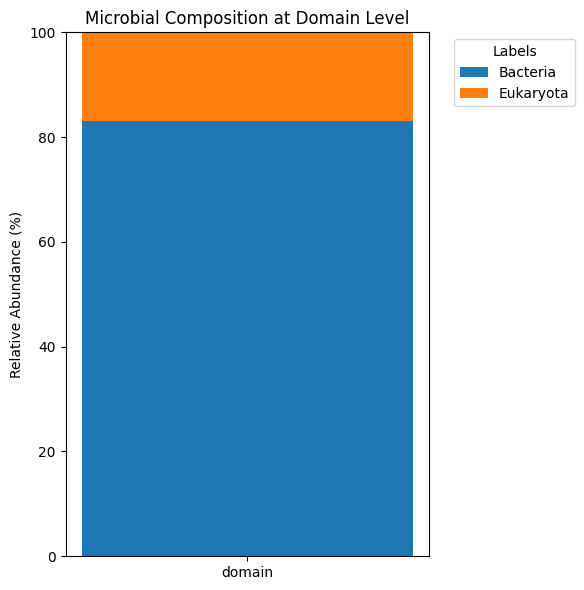

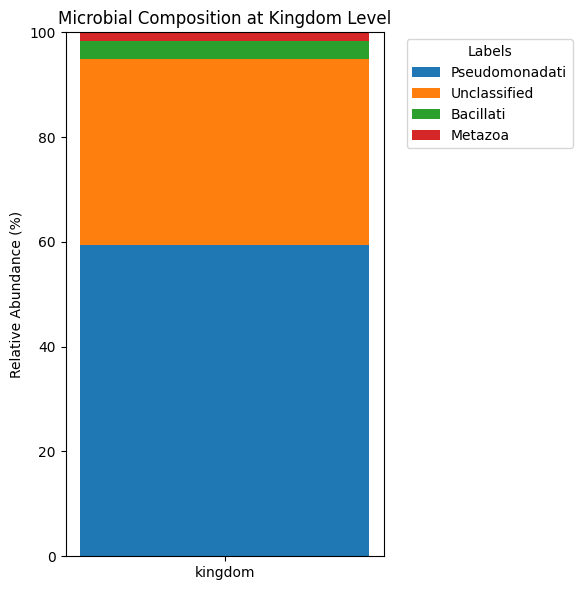

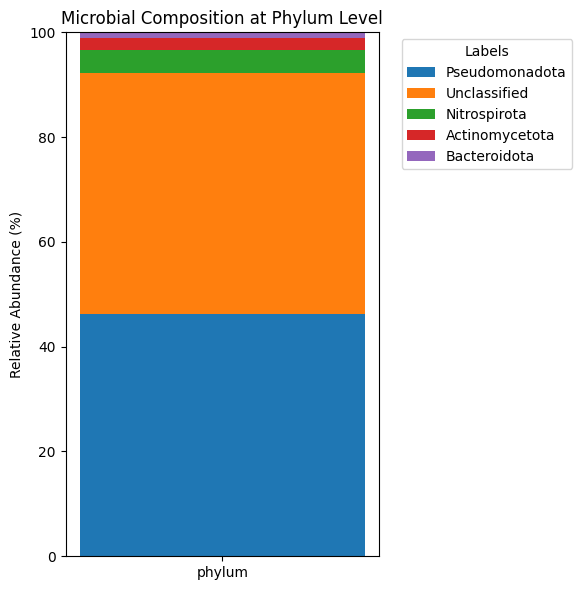

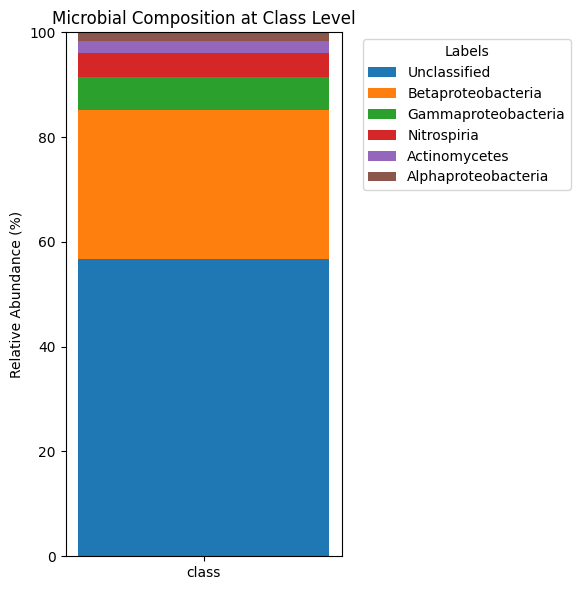

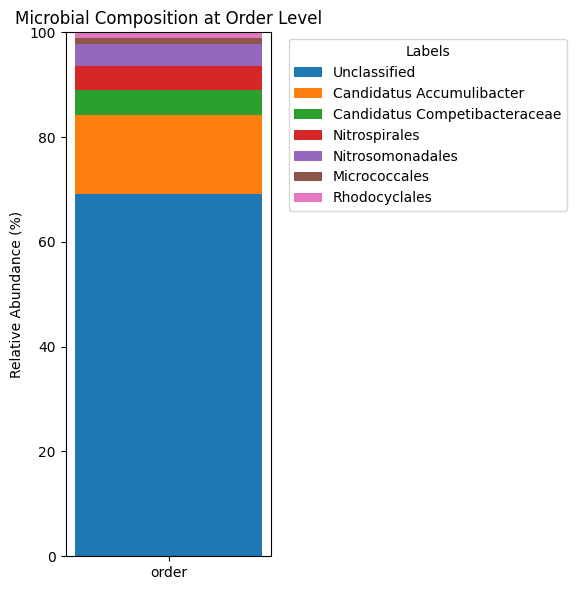

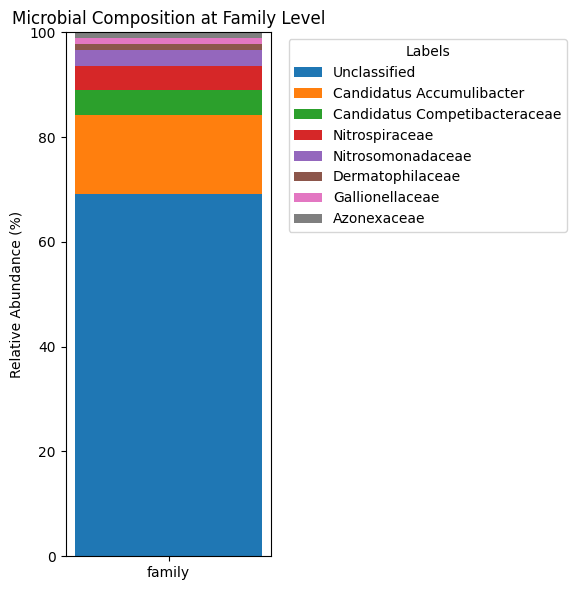

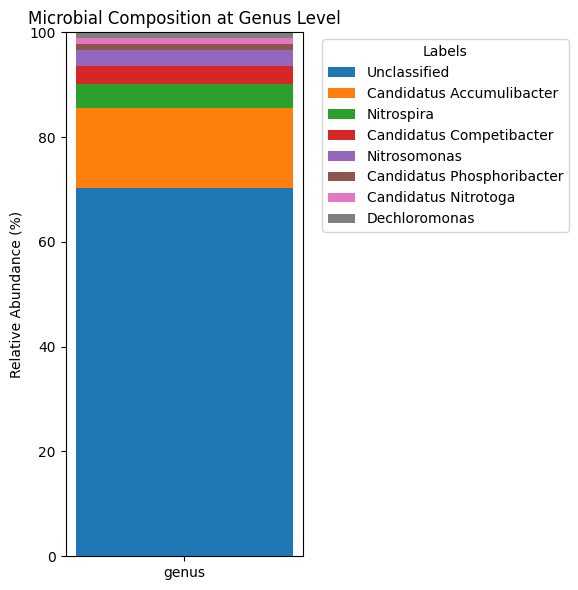

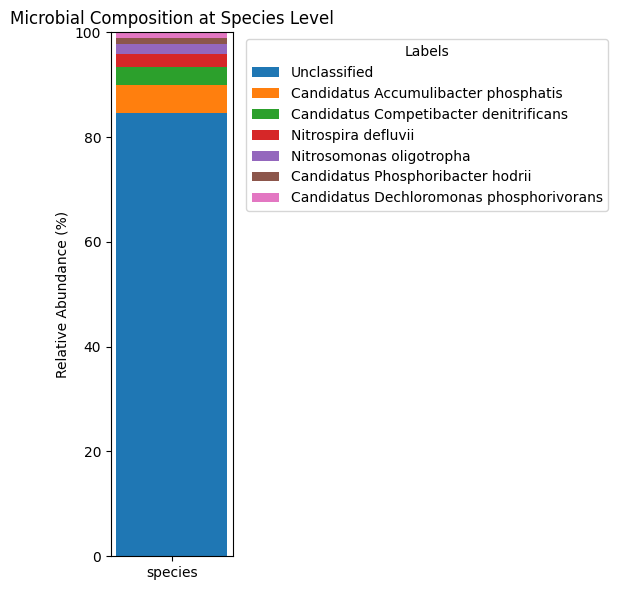

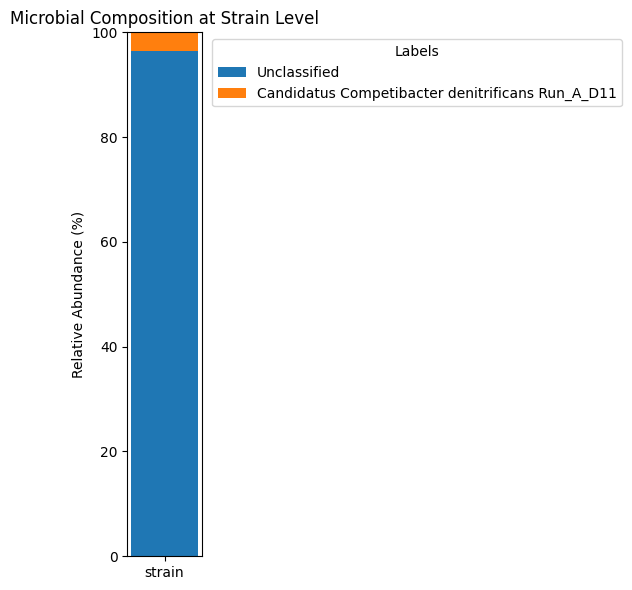

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Step: Loop through each rank and create a stacked bar chart
for rank, label_counts in rank_label_counts.items():
    # Convert the label counts (Series) to a DataFrame with percentages
    df = label_counts.reset_index()
    df.columns = ["Label", "Count"]
    df["Percent"] = df["Count"] / df["Count"].sum() * 100

    # Sort labels by abundance for consistent stacking
    df = df.sort_values(by="Percent", ascending=False)

    # Plot settings
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a single stacked bar for the current rank
    bottom = 0
    for _, row in df.iterrows():
        ax.bar(rank, row["Percent"], bottom=bottom, label=row["Label"])
        bottom += row["Percent"]

    # Final adjustments
    ax.set_title(f"Microbial Composition at {rank.capitalize()} Level")
    ax.set_ylabel("Relative Abundance (%)")
    ax.set_ylim(0, 100)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")

    plt.tight_layout()
    plt.show()

In [ ]:
# This script first fetches the proteome IDs for a given organism name or taxon ID and only keeps either "reference" or "other" proteomes
# Then it searches the proteome IDs in Uniprotkb and then downloads the protein sequences in FASTA format.
import os
import requests
from datetime import datetime

# === 1. Session folder ===
session_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"fasta_proteomes_proteomes_api/session_{session_time}"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Output folder created: {output_dir}\n")

# === 2. Get proteome IDs (try organism name first, fallback to taxonomy ID) ===
def get_proteome_ids(name, taxon_id):
    headers = {"User-Agent": "Mozilla/5.0"}
    base_url = "https://rest.uniprot.org/proteomes/search"
    proteomes = []

    # --- Attempt 1: Search by organism name
    try:
        params_name = {"query": f'organism:"{name}"', "format": "json", "size": 100}
        response = requests.get(base_url, params=params_name, headers=headers, timeout=30)
        if response.ok:
            results = response.json().get("results", [])
            if results:
                for entry in results:
                    proteome_id = entry.get("upid")
                    org_name = entry.get("organism", {}).get("scientificName", "Unknown")
                    proteomes.append((proteome_id, org_name))
                return proteomes
    except Exception as e:
        print(f"⚠️ Name search failed for '{name}': {e}")

    # --- Attempt 2: Fallback to taxonomy ID
    try:
        params_tax = {"query": f"taxonomy_id:{taxon_id}", "format": "json", "size": 100}
        response = requests.get(base_url, params=params_tax, headers=headers, timeout=30)
        if response.ok:
            results = response.json().get("results", [])
            for entry in results:
                proteome_id = entry.get("upid")
                org_name = entry.get("organism", {}).get("scientificName", "Unknown")
                proteomes.append((proteome_id, org_name))
    except Exception as e:
        print(f"❌ Taxonomy ID search failed for '{name}' (ID: {taxon_id}): {e}")

    return proteomes

# === 3. Download proteins from proteome ID ===
def download_proteome_fasta(proteome_id, organism_name, output_dir):
    headers = {"User-Agent": "Mozilla/5.0"}
    url = f"https://rest.uniprot.org/uniprotkb/stream?query=proteome:{proteome_id}&format=fasta&size=500"

    try:
        response = requests.get(url, headers=headers, timeout=60)
        if response.ok and response.text.strip():
            num_proteins = response.text.count(">")
            safe_name = organism_name.replace(" ", "_")
            file_name = f"{safe_name}_{proteome_id}.fasta"
            file_path = os.path.join(output_dir, file_name)
            with open(file_path, "w") as f:
                f.write(response.text)
            print(f"✅ {num_proteins} proteins saved for {organism_name} (Proteome: {proteome_id})")
        else:
            print(f"❌ No proteins found for proteome {proteome_id} ({organism_name})")
    except Exception as e:
        print(f"❌ Failed to download {proteome_id}: {e}")

# === 4. Set rank and get valid taxon names ===
rank = "species"  # Change to e.g. "genus" or "family" if needed
top_labels = merged_df[rank].dropna().unique().tolist()
top_labels = [label for label in top_labels if label.lower() != "unclassified"]

# === 5. Map label → taxon_id from merged_df (using Global LCA column) ===
label_to_taxid = (
    merged_df[merged_df[rank].isin(top_labels)]
    .drop_duplicates(subset=[rank])
    .set_index(rank)["Global LCA"]
    .to_dict()
)

# === 6. Loop and download proteomes ===
for label in top_labels:
    taxon_id = label_to_taxid.get(label)
    print(f"\n🔍 Searching proteomes for {label} (Taxon ID: {taxon_id})")
    if not taxon_id:
        print(f"⚠️ Skipping {label} (no taxon ID found)")
        continue

    proteome_list = get_proteome_ids(label, taxon_id)
    print(f"📦 Found {len(proteome_list)} proteomes for {label}.")

    for proteome_id, organism_name in proteome_list:
        if proteome_id:
            download_proteome_fasta(proteome_id, organism_name, output_dir)


📁 Output folder created: fasta_proteomes_proteomes_api/session_2025-05-12_15-37-45


🔍 Searching proteomes for NA (Taxon ID: 1234)
📦 Found 100 proteomes for NA.

🔍 Searching proteomes for Candidatus Competibacter denitrificans (Taxon ID: 1400863)
📦 Found 1 proteomes for Candidatus Competibacter denitrificans.

🔍 Searching proteomes for Candidatus Accumulibacter phosphatis (Taxon ID: 327160)
📦 Found 12 proteomes for Candidatus Accumulibacter phosphatis.

🔍 Searching proteomes for Nitrospira defluvii (Taxon ID: 330214)
📦 Found 2 proteomes for Nitrospira defluvii.

🔍 Searching proteomes for Candidatus Phosphoribacter hodrii (Taxon ID: 2953743)
📦 Found 3 proteomes for Candidatus Phosphoribacter hodrii.

🔍 Searching proteomes for Candidatus Dechloromonas phosphorivorans (Taxon ID: 2899244)
📦 Found 3 proteomes for Candidatus Dechloromonas phosphorivorans.

🔍 Searching proteomes for Nitrosomonas oligotropha (Taxon ID: 42354)
📦 Found 4 proteomes for Nitrosomonas oligotropha.


In [ ]:
import os

# === 1. Define input and output ===
input_folder = "fasta_proteomes_proteomes_api/proteins_from_proteomes_species"
output_file = "fasta_proteomes_proteomes_api/pept2lca_species_proteomes_db.fasta"

# === 2. Combine all FASTA content ===
total_proteins = 0

with open(output_file, "w") as outfile:
    for filename in os.listdir(input_folder):
        if filename.endswith(".fasta"):
            filepath = os.path.join(input_folder, filename)
            with open(filepath, "r") as f:
                fasta_data = f.read()
                protein_count = fasta_data.count(">")
                total_proteins += protein_count
                outfile.write(fasta_data)
            print(f"✅ {protein_count} proteins from {filename} added.")

# === 3. Final result ===
print(f"\n🎯 Combined FASTA saved to: {output_file}")
print(f"📊 Total number of proteins in the database: {total_proteins}")

✅ 12911 proteins from Candidatus_Accumulibacter_combined.fasta added.
✅ 4014 proteins from Candidatus_Competibacter_combined.fasta added.
✅ 9426 proteins from Candidatus_Phosphoribacter.fasta added.
✅ 7439 proteins from Dechloromonas_phosphorivorans.fasta added.
✅ 41334 proteins from NA_combined_proteomes.fasta added.
✅ 3170 proteins from Nitrosomonas_oligotropha.fasta added.
✅ 4263 proteins from Nitrospira_defluvii_proteins.fasta added.

🎯 Combined FASTA saved to: fasta_proteomes_proteomes_api/species_database_combined.fasta
📊 Total number of proteins in the database: 82557


In [30]:
import os
import requests
import pandas as pd

# === 1. Load the TSV file from manually_downloaded_proteomes ===
tsv_path = "manually_downloaded_proteomes/proteomes_Dechloromonas_phosphorivorans_2025_05_12.tsv"
df = pd.read_csv(tsv_path, sep="\t")

# === 2. Create a new output session folder ===
session_name = "session_Candidatus_Competibacter_combined"
output_dir = os.path.join("fasta_proteomes_proteomes_api", session_name)
os.makedirs(output_dir, exist_ok=True)
combined_fasta_path = os.path.join(output_dir, "Dechloromonas_phosphorivorans.fasta")

# === 3. Define function to download FASTA from UniProt ===
def download_fasta_for_proteome(proteome_id):
    url = f"https://rest.uniprot.org/uniprotkb/stream?query=proteome:{proteome_id}&format=fasta"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    return response.text if response.ok and response.text.strip() else None

# === 4. Combine all FASTA sequences ===
proteome_list = list(zip(df["Proteome Id"], df["Organism"]))
total_proteins = 0

with open(combined_fasta_path, "w") as outfile:
    for pid, organism in proteome_list:
        fasta = download_fasta_for_proteome(pid)
        if fasta:
            protein_count = fasta.count(">")
            total_proteins += protein_count
            outfile.write(fasta)
            print(f"✅ Downloaded {protein_count} proteins for {pid} ({organism})")
        else:
            print(f"❌ Failed to download {pid} ({organism})")

print(f"\n🎯 Combined FASTA saved to: {combined_fasta_path}")
print(f"📊 Total proteins downloaded: {total_proteins}")

✅ Downloaded 3814 proteins for UP000739411 (Candidatus Dechloromonas phosphorivorans)
✅ Downloaded 3625 proteins for UP000808146 (Candidatus Dechloromonas phosphorivorans)

🎯 Combined FASTA saved to: fasta_proteomes_proteomes_api\session_Candidatus_Competibacter_combined\Dechloromonas_phosphorivorans.fasta
📊 Total proteins downloaded: 7439


In [ ]:
# This script uses the API that downloads proteins from Uniprotkb directly for a given organism name or taxon ID instead of fetching proteomes first. 
import os
import requests

def download_uniprot_fasta_adaptive(organism_name, taxon_id, label, output_dir,
                                     reviewed_threshold=30000, reviewed_min_count=5000):
    """
    Smart UniProt FASTA downloader:
    - Tries organism name first
    - Chooses reviewed/unreviewed based on protein abundance
    - Falls back on taxon ID if necessary
    """
    base_url = "https://rest.uniprot.org/uniprotkb"
    headers = {"User-Agent": "Mozilla/5.0"}

    def get_count(query):
        url = f"{base_url}/search?query={query}&size=1&format=list"
        r = requests.get(url, headers=headers)
        if r.status_code == 200:
            return int(r.headers.get("X-Total-Results", 0))
        return 0

    def fetch_fasta(query, label, method_desc):
        fasta_url = f"{base_url}/stream?query={query}&format=fasta&size=500"
        r = requests.get(fasta_url, headers=headers)
        if r.ok and r.text.strip():
            num_proteins = r.text.count(">")
            filename = f"{label.replace(' ', '_')}_{taxon_id}.fasta"
            with open(os.path.join(output_dir, filename), "w") as f:
                f.write(r.text)
            print(f"✅ {num_proteins} proteins saved for {label} using {method_desc}.")
            return True
        return False

    # === Try with organism name ===
    query_base_name = f'organism_name:"{organism_name}"'
    total_name = get_count(f"{query_base_name} AND reviewed:false")
    reviewed_name = get_count(f"{query_base_name} AND reviewed:true")

    if total_name == 0 and reviewed_name == 0:
        # === Try taxon ID instead ===
        query_base_id = f'taxonomy_id:{taxon_id}'
        total_id = get_count(f"{query_base_id} AND reviewed:false")
        reviewed_id = get_count(f"{query_base_id} AND reviewed:true")

        if total_id == 0 and reviewed_id == 0:
            print(f"❌ No proteins found for {label} (neither name nor taxon ID).")
            return

        # Decide which ID-based query to use
        if total_id > reviewed_threshold and reviewed_id > reviewed_min_count:
            query = f"{query_base_id} AND reviewed:true"
            method = "reviewed taxon ID"
        else:
            query = f"{query_base_id} AND reviewed:false"
            method = "unreviewed taxon ID"

    else:
        # Decide which name-based query to use
        if total_name > reviewed_threshold and reviewed_name > reviewed_min_count:
            query = f"{query_base_name} AND reviewed:true"
            method = "reviewed name"
        else:
            query = f"{query_base_name} AND reviewed:false"
            method = "unreviewed name"

    # === Try to fetch ===
    if not fetch_fasta(query, label, method):
        print(f"❌ FASTA fetch failed for {label} with {method}.")


In [20]:
'''
import datetime
import os

# === Step 1: Define target rank (species) ===
target_rank = "family"  # You can change to 'genus', 'family', etc.

# === Step 2: Get unique classified taxa ===
top_labels = merged_df[target_rank].dropna().unique().tolist()
top_labels = [label for label in top_labels if label.lower() != "unclassified"]

# === Step 3: Create output folder ===
session_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"fasta_proteomes/session_{session_time}"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Output folder created: {output_dir}")

# === Step 4: Create mapping of label → taxon_id and label → name ===
label_to_taxid = {}
label_to_name = {}

for tid, row in lineage_df.iterrows():
    label = row.get(target_rank)
    if label in top_labels:
        label_to_taxid[label] = tid
        label_to_name[label] = row.get(target_rank)

# === Step 5: Loop and download ===
for label in top_labels:
    if label in label_to_taxid:
        tid = label_to_taxid[label]
        name = label_to_name[label]
        download_uniprot_fasta_adaptive(name, tid, label, output_dir)
'''

'\nimport datetime\nimport os\n\n# === Step 1: Define target rank (species) ===\ntarget_rank = "family"  # You can change to \'genus\', \'family\', etc.\n\n# === Step 2: Get unique classified taxa ===\ntop_labels = merged_df[target_rank].dropna().unique().tolist()\ntop_labels = [label for label in top_labels if label.lower() != "unclassified"]\n\n# === Step 3: Create output folder ===\nsession_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")\noutput_dir = f"fasta_proteomes/session_{session_time}"\nos.makedirs(output_dir, exist_ok=True)\nprint(f"📁 Output folder created: {output_dir}")\n\n# === Step 4: Create mapping of label → taxon_id and label → name ===\nlabel_to_taxid = {}\nlabel_to_name = {}\n\nfor tid, row in lineage_df.iterrows():\n    label = row.get(target_rank)\n    if label in top_labels:\n        label_to_taxid[label] = tid\n        label_to_name[label] = row.get(target_rank)\n\n# === Step 5: Loop and download ===\nfor label in top_labels:\n    if label in label_

In [21]:
'''
import os

def merge_fasta_files(session_folder, output_filename="custom_database.fasta"):
    """
    Merge all .fasta files in a folder into a single file.
    Saves the output in the same folder.
    """
    output_path = os.path.join(session_folder, output_filename)
    fasta_files = [f for f in os.listdir(session_folder) if f.endswith(".fasta") and f != output_filename]

    if not fasta_files:
        print("⚠️ No FASTA files found to merge.")
        return

    with open(output_path, "w") as outfile:
        for fname in fasta_files:
            full_path = os.path.join(session_folder, fname)
            with open(full_path, "r") as infile:
                content = infile.read().strip()
                if content:
                    outfile.write(content + "\n")

    print(f"✅ Merged {len(fasta_files)} FASTA files into '{output_filename}' ({output_path})")
'''

'\nimport os\n\ndef merge_fasta_files(session_folder, output_filename="custom_database.fasta"):\n    """\n    Merge all .fasta files in a folder into a single file.\n    Saves the output in the same folder.\n    """\n    output_path = os.path.join(session_folder, output_filename)\n    fasta_files = [f for f in os.listdir(session_folder) if f.endswith(".fasta") and f != output_filename]\n\n    if not fasta_files:\n        print("⚠️ No FASTA files found to merge.")\n        return\n\n    with open(output_path, "w") as outfile:\n        for fname in fasta_files:\n            full_path = os.path.join(session_folder, fname)\n            with open(full_path, "r") as infile:\n                content = infile.read().strip()\n                if content:\n                    outfile.write(content + "\n")\n\n    print(f"✅ Merged {len(fasta_files)} FASTA files into \'{output_filename}\' ({output_path})")\n'

In [22]:
# === Example usage ===
# Just call this after your downloads are done:
#merge_fasta_files(output_dir)